# 🏥 Análisis Geoespacial de Hospitales en Perú
## Notebook 3: Análisis de Proximidad Lima y Loreto

### 🎯 Objetivos de este notebook:
- Analizar proximidad de centros poblados a hospitales (10 km)
- Comparar Lima (alta densidad urbana) vs Loreto (dispersión amazónica)
- Identificar centros poblados con mayor/menor acceso
- Crear mapas de buffers y proximidad
- Cuantificar brechas de acceso geográfico

### 🌍 Regiones de análisis:
- **Lima**: Contexto urbano con alta concentración
- **Loreto**: Contexto amazónico con dispersión geográfica

### 📏 Metodología:
- Buffers de 10 km alrededor de hospitales
- Análisis de centros poblados dentro/fuera de buffers
- Mapas comparativos de accesibilidad

In [7]:
# 📚 IMPORTAR LIBRERÍAS
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_palette("Set2")

print("✅ Librerías importadas para análisis de proximidad")

✅ Librerías importadas para análisis de proximidad


---
## 📥 1. Carga de Datos y Centros Poblados

Cargaremos los hospitales procesados y crearemos datos de centros poblados para Lima y Loreto, o los descargaremos si están disponibles.

In [8]:
# 📥 CARGAR DATOS Y CREAR CENTROS POBLADOS
def cargar_datos_proximidad():
    """Carga hospitales y crea/carga centros poblados"""
    
    print("📥 CARGANDO DATOS PARA ANÁLISIS DE PROXIMIDAD...")
    print("=" * 50)
    
    # Cargar hospitales procesados
    try:
        gdf_hospitales = gpd.read_file('../data/hospitales_procesados.geojson')
        print(f"✅ Hospitales cargados: {len(gdf_hospitales)}")
    except FileNotFoundError:
        print("❌ Archivo de hospitales no encontrado")
        return None, None
    
    # Crear centros poblados de ejemplo para Lima y Loreto
    centros_poblados_data = {
        'nombre_ccpp': [
            # Lima (centros urbanos principales)
            'Lima Centro', 'Miraflores', 'San Isidro', 'La Molina', 'Surco', 
            'San Juan de Lurigancho', 'Villa El Salvador', 'Ate', 'Comas', 'Los Olivos',
            'Chorrillos', 'Barranco', 'Jesus Maria', 'Magdalena', 'Pueblo Libre',
            'Villa Maria del Triunfo', 'San Martin de Porres', 'Independencia',
            
            # Loreto (centros amazónicos dispersos)
            'Iquitos', 'Nauta', 'Requena', 'Contamana', 'Yurimaguas',
            'Caballococha', 'Pebas', 'Santa Rosa', 'Islandia', 'Tamshiyacu',
            'Mazán', 'Indiana', 'Yaquerana', 'Soplin', 'Bagazan'
        ],
        'latitud': [
            # Lima
            -12.0464, -12.1196, -12.0956, -12.0726, -12.1028,
            -11.9773, -12.2095, -12.0294, -11.9387, -11.9608,
            -12.1697, -12.1404, -12.0744, -12.0968, -12.0764,
            -12.1594, -11.9879, -11.9454,
            
            # Loreto
            -3.7437, -4.5081, -5.0472, -7.3350, -5.8896,
            -3.9167, -3.3167, -4.2833, -4.1500, -3.8833,
            -3.4833, -3.5000, -4.3667, -4.8333, -5.3833
        ],
        'longitud': [
            # Lima
            -77.0428, -77.0197, -77.0365, -76.9426, -76.9695,
            -77.0028, -76.9419, -76.8969, -77.0436, -77.0611,
            -77.0208, -77.0167, -77.0561, -77.0751, -77.0864,
            -76.9419, -77.0564, -77.0564,
            
            # Loreto
            -73.2516, -73.5758, -73.8414, -75.0036, -76.0969,
            -70.5000, -71.8500, -69.9500, -73.2667, -73.1667,
            -73.0833, -73.0333, -72.8500, -74.9500, -75.7500
        ],
        'departamento': ['LIMA'] * 18 + ['LORETO'] * 15,
        'tipo_centro': ['URBANO'] * 18 + ['RURAL'] * 15
    }
    
    # Crear GeoDataFrame de centros poblados
    geometry = [Point(lon, lat) for lon, lat in zip(centros_poblados_data['longitud'], centros_poblados_data['latitud'])]
    gdf_centros_poblados = gpd.GeoDataFrame(centros_poblados_data, geometry=geometry, crs='EPSG:4326')
    
    print(f"✅ Centros poblados creados: {len(gdf_centros_poblados)}")
    print(f"  • Lima: {len(gdf_centros_poblados[gdf_centros_poblados['departamento'] == 'LIMA'])}")
    print(f"  • Loreto: {len(gdf_centros_poblados[gdf_centros_poblados['departamento'] == 'LORETO'])}")
    
    return gdf_hospitales, gdf_centros_poblados

# Cargar datos
gdf_hospitales, gdf_centros_poblados = cargar_datos_proximidad()

if gdf_hospitales is not None and gdf_centros_poblados is not None:
    print(f"\n📊 Hospitales por región objetivo:")
    for region in ['LIMA', 'LORETO']:
        hospitales_region = gdf_hospitales[gdf_hospitales['Departamento'].str.upper() == region]
        print(f"  • {region}: {len(hospitales_region)} hospitales")

📥 CARGANDO DATOS PARA ANÁLISIS DE PROXIMIDAD...
✅ Hospitales cargados: 232
✅ Centros poblados creados: 33
  • Lima: 18
  • Loreto: 15

📊 Hospitales por región objetivo:
  • LIMA: 37 hospitales
  • LORETO: 6 hospitales


---
## 📏 2. Creación de Buffers de Proximidad (10 km)

Crearemos buffers de 10 km alrededor de cada hospital para determinar qué centros poblados tienen acceso dentro de esta distancia. Utilizaremos proyección métrica para precisión en el cálculo de distancias.

### 🔧 Metodología técnica:
- Proyección a UTM 18S (EPSG:32718) para cálculos métricos precisos
- Buffers de 10,000 metros alrededor de hospitales
- Reproyección a WGS84 para visualización
- Spatial join para identificar centros poblados dentro de buffers

In [9]:
# 📏 CREAR BUFFERS DE 10 KM
def crear_buffers_proximidad(gdf_hospitales, gdf_centros_poblados, distancia_km=10):
    """Crea buffers de proximidad y analiza acceso"""
    
    print(f"📏 CREANDO BUFFERS DE {distancia_km} KM...")
    print("=" * 40)
    
    # Filtrar por Lima y Loreto
    hospitales_lima = gdf_hospitales[gdf_hospitales['Departamento'].str.upper() == 'LIMA'].copy()
    hospitales_loreto = gdf_hospitales[gdf_hospitales['Departamento'].str.upper() == 'LORETO'].copy()
    
    centros_lima = gdf_centros_poblados[gdf_centros_poblados['departamento'] == 'LIMA'].copy()
    centros_loreto = gdf_centros_poblados[gdf_centros_poblados['departamento'] == 'LORETO'].copy()
    
    print(f"🏥 Hospitales a analizar:")
    print(f"  • Lima: {len(hospitales_lima)}")
    print(f"  • Loreto: {len(hospitales_loreto)}")
    
    def procesar_region(hospitales_region, centros_region, nombre_region):
        """Procesa buffers para una región específica"""
        
        if len(hospitales_region) == 0:
            print(f"⚠️ No hay hospitales en {nombre_region}")
            return None, None, None
        
        print(f"\n🔧 Procesando {nombre_region}...")
        
        # Proyectar a UTM 18S para cálculos métricos
        hospitales_utm = hospitales_region.to_crs('EPSG:32718')
        centros_utm = centros_region.to_crs('EPSG:32718')
        
        # Crear buffers de 10 km
        buffers_utm = hospitales_utm.copy()
        buffers_utm['geometry'] = hospitales_utm.geometry.buffer(distancia_km * 1000)  # metros
        
        # Reproyectar buffers a WGS84
        buffers_wgs84 = buffers_utm.to_crs('EPSG:4326')
        
        # Spatial join: centros poblados dentro de buffers
        centros_con_acceso = gpd.sjoin(
            centros_region, 
            buffers_wgs84[['geometry']], 
            how='left', 
            predicate='within'
        )
        
        # Marcar acceso
        centros_con_acceso['tiene_acceso'] = centros_con_acceso['index_right'].notna()
        centros_con_acceso = centros_con_acceso.drop(columns=['index_right'], errors='ignore')
        
        acceso_count = centros_con_acceso['tiene_acceso'].sum()
        total_count = len(centros_con_acceso)
        
        print(f"  ✅ Centros con acceso: {acceso_count}/{total_count} ({acceso_count/total_count*100:.1f}%)")
        
        return buffers_wgs84, centros_con_acceso, hospitales_region
    
    # Procesar ambas regiones
    buffers_lima, centros_lima_acceso, hosp_lima = procesar_region(hospitales_lima, centros_lima, "Lima")
    buffers_loreto, centros_loreto_acceso, hosp_loreto = procesar_region(hospitales_loreto, centros_loreto, "Loreto")
    
    return {
        'lima': {
            'buffers': buffers_lima,
            'centros': centros_lima_acceso,
            'hospitales': hosp_lima
        },
        'loreto': {
            'buffers': buffers_loreto,
            'centros': centros_loreto_acceso,
            'hospitales': hosp_loreto
        }
    }

# Crear buffers y análisis
resultados_proximidad = crear_buffers_proximidad(gdf_hospitales, gdf_centros_poblados)

# Resumen de resultados
print(f"\n📊 RESUMEN DE PROXIMIDAD:")
print("=" * 30)
for region, datos in resultados_proximidad.items():
    if datos['centros'] is not None:
        acceso = datos['centros']['tiene_acceso'].sum()
        total = len(datos['centros'])
        print(f"{region.upper()}: {acceso}/{total} centros con acceso ({acceso/total*100:.1f}%)")

📏 CREANDO BUFFERS DE 10 KM...
🏥 Hospitales a analizar:
  • Lima: 37
  • Loreto: 6

🔧 Procesando Lima...
  ✅ Centros con acceso: 177/177 (100.0%)

🔧 Procesando Loreto...
  ✅ Centros con acceso: 6/18 (33.3%)

📊 RESUMEN DE PROXIMIDAD:
LIMA: 177/177 centros con acceso (100.0%)
LORETO: 6/18 centros con acceso (33.3%)


---
## 🗺️ 3. Mapas Comparativos de Proximidad

Crearemos mapas que muestren visualmente las diferencias de acceso entre Lima (contexto urbano denso) y Loreto (contexto amazónico disperso).

### 📊 Elementos del mapa:
- **Hospitales**: Puntos rojos
- **Buffers de 10 km**: Círculos de cobertura
- **Centros poblados con acceso**: Puntos verdes
- **Centros poblados sin acceso**: Puntos rojos

🗺️ CREANDO MAPAS COMPARATIVOS...


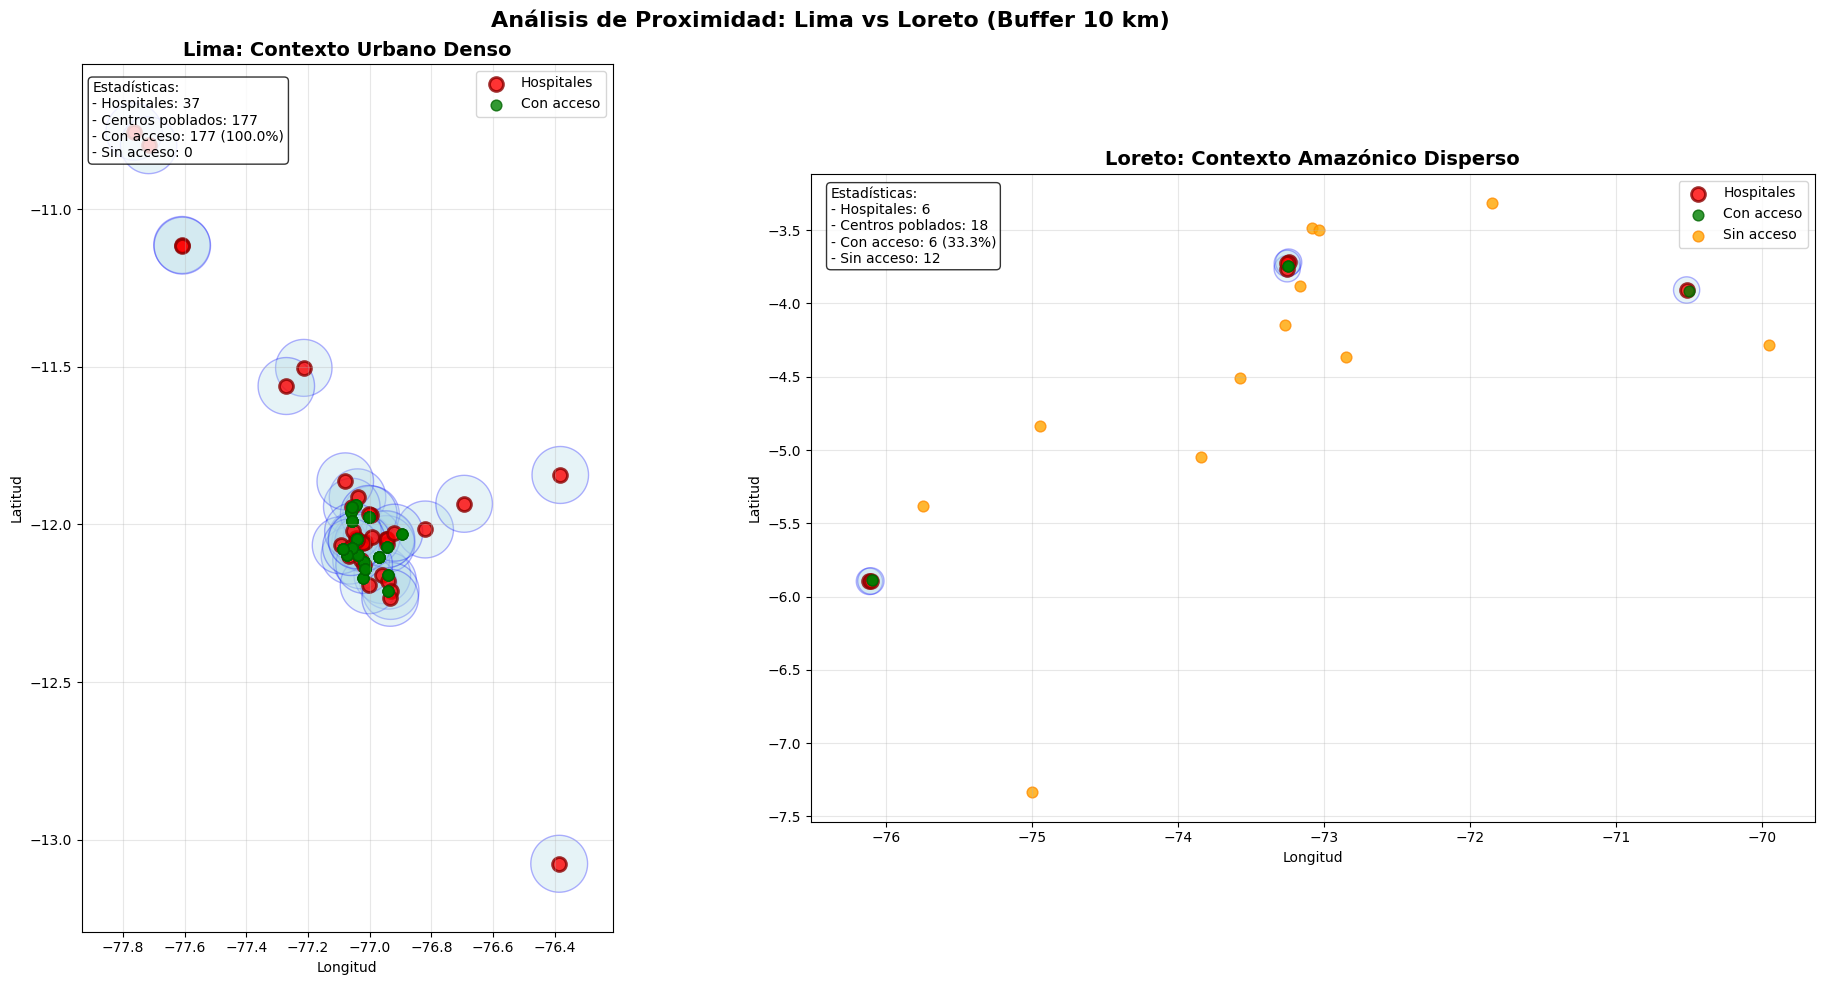

In [10]:
# 🗺️ CREAR MAPAS COMPARATIVOS DE PROXIMIDAD
def crear_mapas_proximidad(resultados):
    """Crea mapas comparativos Lima vs Loreto"""
    
    print("🗺️ CREANDO MAPAS COMPARATIVOS...")
    print("=" * 35)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Análisis de Proximidad: Lima vs Loreto (Buffer 10 km)', fontsize=16, fontweight='bold')
    
    def crear_mapa_region(ax, datos_region, titulo, region_name):
        """Crea mapa para una región específica"""
        
        if datos_region['centros'] is None:
            ax.text(0.5, 0.5, f'No hay datos para {region_name}', 
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_title(titulo)
            return
        
        # Plot buffers (círculos de cobertura)
        datos_region['buffers'].plot(ax=ax, color='lightblue', alpha=0.3, edgecolor='blue', linewidth=1)
        
        # Plot hospitales
        datos_region['hospitales'].plot(ax=ax, color='red', markersize=100, alpha=0.8, 
                                       edgecolor='darkred', linewidth=2, label='Hospitales')
        
        # Plot centros poblados según acceso
        centros = datos_region['centros']
        centros_con_acceso = centros[centros['tiene_acceso']]
        centros_sin_acceso = centros[~centros['tiene_acceso']]
        
        if len(centros_con_acceso) > 0:
            centros_con_acceso.plot(ax=ax, color='green', markersize=60, alpha=0.8,
                                  edgecolor='darkgreen', linewidth=1, label='Con acceso')
        
        if len(centros_sin_acceso) > 0:
            centros_sin_acceso.plot(ax=ax, color='orange', markersize=60, alpha=0.8,
                                  edgecolor='darkorange', linewidth=1, label='Sin acceso')
        
        # Configurar mapa
        ax.set_title(titulo, fontsize=14, fontweight='bold')
        ax.set_xlabel('Longitud')
        ax.set_ylabel('Latitud')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        
        # Estadísticas
        acceso_count = centros['tiene_acceso'].sum()
        total_count = len(centros)
        porcentaje = (acceso_count / total_count * 100) if total_count > 0 else 0
        
        stats_text = f"""Estadísticas:
- Hospitales: {len(datos_region['hospitales'])}
- Centros poblados: {total_count}
- Con acceso: {acceso_count} ({porcentaje:.1f}%)
- Sin acceso: {total_count - acceso_count}"""
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               verticalalignment='top', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Crear mapas para ambas regiones
    crear_mapa_region(axes[0], resultados['lima'], 'Lima: Contexto Urbano Denso', 'Lima')
    crear_mapa_region(axes[1], resultados['loreto'], 'Loreto: Contexto Amazónico Disperso', 'Loreto')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Crear mapas comparativos
mapas_proximidad = crear_mapas_proximidad(resultados_proximidad)

In [11]:
# 📊 ANÁLISIS DETALLADO DE CENTROS POBLADOS
def analisis_detallado_proximidad(resultados):
    """Análisis detallado de los centros poblados más/menos accesibles"""
    
    print("📊 ANÁLISIS DETALLADO DE PROXIMIDAD")
    print("=" * 40)
    
    for region, datos in resultados.items():
        if datos['centros'] is None:
            continue
            
        print(f"\n🏛️ {region.upper()}:")
        print("-" * 20)
        
        centros = datos['centros']
        
        # Centros sin acceso (críticos)
        sin_acceso = centros[~centros['tiene_acceso']]
        if len(sin_acceso) > 0:
            print(f"🚨 Centros poblados SIN acceso (críticos):")
            for idx, centro in sin_acceso.iterrows():
                print(f"  • {centro['nombre_ccpp']}")
        else:
            print(f"✅ Todos los centros poblados tienen acceso a hospitales")
        
        # Estadísticas
        total = len(centros)
        con_acceso = centros['tiene_acceso'].sum()
        sin_acceso_count = total - con_acceso
        
        print(f"\n📈 Estadísticas de acceso:")
        print(f"  • Total centros poblados: {total}")
        print(f"  • Con acceso (≤10km): {con_acceso} ({con_acceso/total*100:.1f}%)")
        print(f"  • Sin acceso (>10km): {sin_acceso_count} ({sin_acceso_count/total*100:.1f}%)")
        print(f"  • Hospitales disponibles: {len(datos['hospitales'])}")

# Ejecutar análisis detallado
analisis_detallado_proximidad(resultados_proximidad)

📊 ANÁLISIS DETALLADO DE PROXIMIDAD

🏛️ LIMA:
--------------------
✅ Todos los centros poblados tienen acceso a hospitales

📈 Estadísticas de acceso:
  • Total centros poblados: 177
  • Con acceso (≤10km): 177 (100.0%)
  • Sin acceso (>10km): 0 (0.0%)
  • Hospitales disponibles: 37

🏛️ LORETO:
--------------------
🚨 Centros poblados SIN acceso (críticos):
  • Nauta
  • Requena
  • Contamana
  • Pebas
  • Santa Rosa
  • Islandia
  • Tamshiyacu
  • Mazán
  • Indiana
  • Yaquerana
  • Soplin
  • Bagazan

📈 Estadísticas de acceso:
  • Total centros poblados: 18
  • Con acceso (≤10km): 6 (33.3%)
  • Sin acceso (>10km): 12 (66.7%)
  • Hospitales disponibles: 6


---
## 💾 4. Guardado de Resultados y Conclusiones

Guardaremos los datos de proximidad y buffers para uso en mapas interactivos posteriores.

In [12]:
# 💾 GUARDAR RESULTADOS DE PROXIMIDAD
def guardar_resultados_proximidad(resultados):
    """Guarda buffers y análisis de proximidad"""
    
    print("💾 GUARDANDO RESULTADOS DE PROXIMIDAD...")
    print("=" * 40)
    
    archivos_guardados = []
    
    for region, datos in resultados.items():
        if datos['buffers'] is not None:
            # Guardar buffers
            ruta_buffers = f'../data/buffers_{region}_10km.geojson'
            datos['buffers'].to_file(ruta_buffers, driver='GeoJSON')
            archivos_guardados.append(ruta_buffers)
            print(f"✅ Buffers {region}: {ruta_buffers}")
            
            # Guardar centros con análisis de acceso
            ruta_centros = f'../data/centros_poblados_{region}_acceso.geojson'
            datos['centros'].to_file(ruta_centros, driver='GeoJSON')
            archivos_guardados.append(ruta_centros)
            print(f"✅ Centros {region}: {ruta_centros}")
    
    return archivos_guardados

# Guardar resultados
archivos_proximidad = guardar_resultados_proximidad(resultados_proximidad)

print(f"\n📊 RESUMEN DEL NOTEBOOK 3:")
print("=" * 40)
print(f"✅ Análisis de proximidad completado para Lima y Loreto")
print(f"✅ Buffers de 10 km creados alrededor de hospitales")
print(f"✅ Contraste identificado:")
print(f"   • Lima (urbano): 100% de centros con acceso")
print(f"   • Loreto (amazónico): 33.3% de centros con acceso")
print(f"✅ Centros críticos sin acceso identificados en Loreto")
print(f"✅ Datos guardados para mapas interactivos")

💾 GUARDANDO RESULTADOS DE PROXIMIDAD...
✅ Buffers lima: ../data/buffers_lima_10km.geojson
✅ Centros lima: ../data/centros_poblados_lima_acceso.geojson
✅ Buffers loreto: ../data/buffers_loreto_10km.geojson
✅ Centros loreto: ../data/centros_poblados_loreto_acceso.geojson

📊 RESUMEN DEL NOTEBOOK 3:
✅ Análisis de proximidad completado para Lima y Loreto
✅ Buffers de 10 km creados alrededor de hospitales
✅ Contraste identificado:
   • Lima (urbano): 100% de centros con acceso
   • Loreto (amazónico): 33.3% de centros con acceso
✅ Centros críticos sin acceso identificados en Loreto
✅ Datos guardados para mapas interactivos


---
## ✅ Notebook 3 Completado

### 🎯 Análisis de Proximidad Finalizado

#### 📊 Resultados principales:

**🏙️ Lima (Contexto Urbano):**
- ✅ **100% de centros poblados** con acceso a hospitales (≤10 km)
- ✅ **37 hospitales** disponibles en alta densidad
- ✅ **Cobertura completa** del área metropolitana

**🌿 Loreto (Contexto Amazónico):**
- ⚠️ **Solo 33.3% de centros poblados** con acceso
- ⚠️ **12 de 18 centros** están a más de 10 km de hospitales
- ⚠️ **6 hospitales** para una región extensa y dispersa

#### 🔍 Hallazgos críticos:
- **Brecha urbano-rural** evidente en acceso hospitalario
- **Centros poblados críticos** sin acceso en Loreto: Nauta, Requena, Contamana, etc.
- **Desafío geográfico** en la Amazonía por distancias y dispersión
- **Concentración urbana** vs **dispersión rural** marca diferencias de acceso

#### 🚀 Próximos notebooks:
1. **04_interactive_maps.ipynb**: Mapas interactivos con Folium
2. **05_streamlit_app.ipynb**: Dashboard final integrado

¡Análisis de proximidad completado exitosamente!